In [124]:
import sys
import os
sys.path.append('../')

In [125]:
import torch
from torch import nn
import numpy as np
import dataset
import importlib
import matplotlib.pyplot as plt

In [220]:
import dataset
importlib.reload(dataset)

<module 'dataset' from 'g:\\Dev\\AI\\Projects\\ImageGeneration\\dataset.py'>

In [221]:
dataset = dataset.AllVae()
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [237]:
class SmallAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),  # 64
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 32
            nn.Conv2d(128, 256, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 16
            nn.Conv2d(256, 256, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 8
            nn.Flatten(),
            nn.Linear(256*8*8, 8),
            nn.LeakyReLU(),
        )

        self.linear_before_decoder = nn.Sequential(
            nn.Linear(8, 256*8*8),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 256, 2, 2), # 16
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 128, 2, 2), # 32
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, 2, 2), # 64
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.linear_before_decoder(x)
        x = x.view(x.size(0), 256, 8, 8)
        return self.decoder(x)

In [173]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),  # 64
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 32
            nn.Conv2d(32, 64, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 16
            nn.Conv2d(64, 64, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 8
            nn.Conv2d(64, 32, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),  # 8
            nn.Flatten(),
            nn.Linear(32*8*8, 8),
        )

        self.linear_before_decoder = nn.Sequential(
            nn.Linear(8, 32*8*8),
            
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 64, 2, 2), # 16
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, 2, 2), # 32
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 32, 2, 2), # 64
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 3, 3, 1, 1),
            nn.Sigmoid(),
        )

        for sm in self.modules():
            if isinstance(sm, nn.Conv2d):
                torch.nn.init.xavier_uniform(sm.weight)

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear_before_decoder(x)
        x = x.view(x.size(0), 32, 8, 8)
        #print(x)
        return self.decoder(x)
    


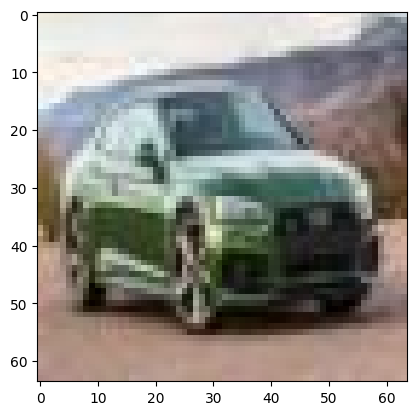

In [66]:
plt.imshow(dataset[3].detach().permute(1,2,0))

In [259]:
DEVICE = 'cpu'
autoencoder = autoencoder.to(DEVICE)

In [256]:
DEVICE = 'cuda'
autoencoder = autoencoder.to(DEVICE)

In [240]:
# initialize model
autoencoder = SmallAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
mse = nn.MSELoss()

In [257]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
mse = nn.MSELoss()

In [34]:
dataset[0].shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.) tensor(1.)
torch.Size([1, 3, 64, 64]) tensor(0.0006, grad_fn=<MseLossBackward0>)


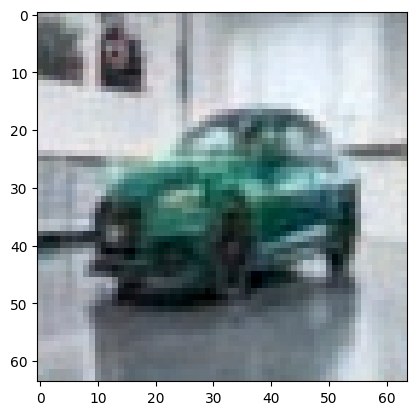

In [279]:
sample_input = next(iter(loader))
print(sample_input.min(), sample_input.max())
sample_output = autoencoder(sample_input[0].unsqueeze(0))
print(sample_output.shape, mse(sample_output, sample_input[0].unsqueeze(0)))
plt.imshow(sample_output.detach().squeeze().permute(1,2,0))

In [258]:
losses = []
for epoch in range(100000):
    for batch_index, batch in enumerate(loader):
        moved = batch.to(DEVICE)

        #print(moved.shape)

        output = autoencoder(moved)

        optimizer.zero_grad()
        loss = mse(output, moved)


        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if len(losses) > 100:
            losses.pop(0)

        avg_loss = sum(losses) / len(losses)

        print(epoch, batch_index, avg_loss, loss.item(), "                                      ", end='\r')

KeyboardInterrupt: 

In [280]:
torch.save(autoencoder, './trained/autoencoder_on_16_images.pth')